## Data Collection 
The ERA5 data is collected using the Climate Data Store API (CDSAPI). Here is the documentation for the [CDSAPI](https://cds.climate.copernicus.eu/api-how-to "CDSAPI-How-To") 

Since there is a limit for the size of the file to be downloaded from CDS servers, data is collected in 3 parts

In [1]:
import cdsapi
import pandas as pd
#import netcdf4
import xarray as xarr # pandas based library for 
            # labeled data with N-D tensors at each dimensions
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [3]:
def pull_data(_start, _end):
    """ Downloads the data from CDS Servers in netcdf format 
    in to the working directory
    
    _start: the starting year type: integer
    _end: the end year type: integer
    does not return anything.
    """
    year_range = pd.date_range(start=str(_start), end=str(_end), freq='YS').year

    years = []
    for item in year_range:
        years.append(str(item))
    c = cdsapi.Client()

    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': '2m_temperature',
            'year': years,
            'month': [
                '01', '02', '06',
                '07', '08', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                49, -128, 23,
                -66,
            ],
            'format': 'netcdf',
        },
        'download.nc')
for _start, _end in [(1979, 1992), (1993,2019), (2020, 2020) ]:
    pull_data(_start, _end )

2020-07-07 23:43:15,907 INFO Welcome to the CDS
2020-07-07 23:43:15,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-07-07 23:43:16,804 INFO Request is queued
2020-07-07 23:43:17,953 INFO Request is running
2020-07-08 10:52:34,609 INFO Request is completed
2020-07-08 10:52:34,612 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1594179084.4056244-9430-10-c5b4b854-16e6-42f0-af39-cd36d2618a6e.nc to download.nc (5.5G)
2020-07-08 11:57:43,167 ERROR Download interupted: HTTPConnectionPool(host='136.156.133.46', port=80): Read timed out. 
2020-07-08 11:57:43,168 ERROR Download incomplete, downloaded 2389307392 byte(s) out of 5946457808
2020-07-08 11:57:43,168 WARNING Sleeping 10 seconds
2020-07-08 11:57:53,171 WARNING Resuming download at byte 2389307392
2020-07-08 12:40:08,142 INFO Download rate 899.8K/s                                                                    


Result(content_length=5946457808,content_type=application/x-netcdf,location=http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1594179084.4056244-9430-10-c5b4b854-16e6-42f0-af39-cd36d2618a6e.nc)

In [3]:
# Read the data Path where it is stored on the Computer
#data_dir = input('Path to the data\n')
data_dir = "C:\\Users\\kurt_\\Data"

In the next part I will import the data parts in netcdf format and merge all parts into a single __xarray dataset__ which is similar to pandas dataframe, but it includes additional labels/dimensions. 

The dimesions in this data format are
* time
* x: latitude
* y: longtitude
* z: pressure level as vertical coodinate

Columns and rows are stored under each combination of these dimensions: 

_For instance for 20 time level, and 10 latitude and 10 longtitude and 1 vertical coord. we have_

`time*x*y*z = 20*10*10*1 = 2000` levels

Therefore, we have the same column and row numbers for each of 2000 levels. The values of columns and rows are unique at each level. 

### Utilizing Dask parallel computing
Since the netCDF files we use here are relatively large, they may exhaust the memory. Instead of numpy array xarray can fill the dataset with dask arrays. All we need to the provide the chunk size argument when we load netcdf file.
Here I use 10 chunks for time dimension. x, y coordinates will be just one chunk each


### Merging data parts


In [31]:
era.close()

<xarray.Dataset>
Dimensions:    (latitude: 105, longitude: 249, time: 61248)
Coordinates:
  * longitude  (longitude) float32 -128.0 -127.75 -127.5 ... -66.5 -66.25 -66.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 23.5 23.25 23.0
  * time       (time) datetime64[ns] 1979-01-01 ... 1992-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(128, 105, 249), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 01:45:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


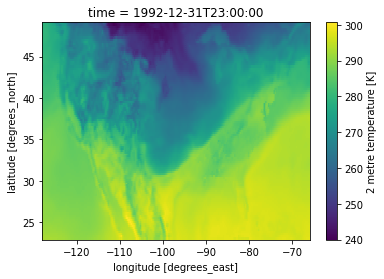

In [10]:
era2 =  xarr.open_dataset(data_dir+r'\era5_1979_1992.nc', chunks={'time': 128})
era2.isel(time=-1)['t2m'].plot()
print(era2)

In [4]:
# Import data as xarray dataset from the directory
era = xarr.open_mfdataset(data_dir+'\\era*.nc', parallel=True, 
                          combine='by_coords', chunks={'time': 128}
                         , engine='netcdf4')
print(era)


<xarray.Dataset>
Dimensions:    (latitude: 105, longitude: 249, time: 179328)
Coordinates:
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float32 -128.0 -127.75 -127.5 ... -66.5 -66.25 -66.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2019-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(128, 105, 249), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 01:45:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


In [4]:
print(f'The chunk size for time dimension is {era.chunks["time"][0]}\n')
print(f'dataset, thus, have {len(era.time)/era.chunks["time"][0]} chunks')

The chunk size for time dimension is 128

dataset, thus, have 1401.0 chunks


# Inspecting data
* Let's take a quick look to the surface temperature in a map first. 

I will plot the first time step for all spatial coordinate just to make sure we are dealing with the correct region (supposed to be continental U.S.)

In [190]:
for var_name, var in era.items():
    print(era[var_name].attrs)
# Let's select the first time step and plot the 2m-air temperature

# Let's check the dimensions
for dim in era.dims:
    dimsize = era.dims[dim]
    print(f'\nData has {dimsize} {dim} ')
    if dim == 'latitude':
        print(f' latitudes: from {float(era[dim].min())} degree South',
     f'to {float(era[dim].max())} degree North')
    if dim == 'longitude':
        print(f' Longitudes: from {float(era[dim].min())} degree East',
     f'to {float(era[dim].max())} degree West')
    if dim == 'time':
        print(f'time: from {pd.to_datetime(era["time"].min().values)} to {pd.to_datetime(era["time"].max().values)} ')

{'units': 'K', 'long_name': '2 metre temperature'}

Data has 105 latitude 
 latitudes: from 23.0 degree South to 49.0 degree North

Data has 249 longitude 
 Longitudes: from -128.0 degree East to -66.0 degree West

Data has 179328 time 
time: from 1979-01-01 00:00:00 to 2019-12-31 23:00:00 


(4920, 105, 249)


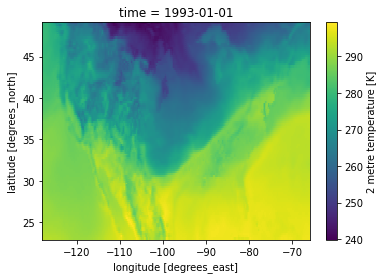

In [96]:
import datetime
print(era.sel(time=datetime.time(10)).t2m.shape)
era.isel(time=0).t2m.plot()

In [89]:
for i in era.dims:
    print(i,era.dims[i])
era['latitude'].max()

latitude 105
longitude 249
time 118080


<xarray.DataArray 'latitude' ()>
array(49.)

In [185]:
pd.to_datetime((era.time.min().values))

Timestamp('1979-01-01 00:00:00')

In [130]:
era.isel(time=0)['time']

<xarray.DataArray 'time' ()>
array('1993-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1993-01-01
Attributes:
    long_name:  time

In [189]:
era['time'].max()

<xarray.DataArray 'time' ()>
array('2019-12-31T23:00:00.000000000', dtype='datetime64[ns]')

In [191]:
pd.date_range('1979-01-01', freq='H', periods=len(era['time']))

DatetimeIndex(['1979-01-01 00:00:00', '1979-01-01 01:00:00',
               '1979-01-01 02:00:00', '1979-01-01 03:00:00',
               '1979-01-01 04:00:00', '1979-01-01 05:00:00',
               '1979-01-01 06:00:00', '1979-01-01 07:00:00',
               '1979-01-01 08:00:00', '1979-01-01 09:00:00',
               ...
               '1999-06-16 14:00:00', '1999-06-16 15:00:00',
               '1999-06-16 16:00:00', '1999-06-16 17:00:00',
               '1999-06-16 18:00:00', '1999-06-16 19:00:00',
               '1999-06-16 20:00:00', '1999-06-16 21:00:00',
               '1999-06-16 22:00:00', '1999-06-16 23:00:00'],
              dtype='datetime64[ns]', length=179328, freq='H')